In [9]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import xarray as xr

import matplotlib.pyplot as plt

from lib import data_loaders

In [10]:
def ngen_csv_to_df(path):
    """Loads nexgen csv outputs

    Parameters
    path (str): locations in nexgen output with catchment .csv files
    """
    cat_paths = list(Path(path).glob("cat-*.csv"))

    catchments = [p.stem for p in cat_paths]
    df_lst = [
        pd.read_csv(p, index_col=["Time"], parse_dates=["Time"]) for p in cat_paths
    ]
    # myDict = {k: pd.read_csv(v, index_col=["Time"]) for (k, v) in zip(cats, cat_paths)}

    return df_lst, catchments


def ngen_df_to_xr(path):
    """Method to parse nexgen model outputs"""

    # get ngen output as list of dfs and names
    df_lst, cats = ngen_csv_to_df(path)

    data_vars = {}

    # Loop through each DataFrame and each variable (column) to create DataArrays
    for df, catchment in zip(df_lst, cats):
        for column in df.columns:
            if column not in data_vars:
                # Initialize a list for this variable if not already present
                data_vars[column] = []
            # Create a DataArray for each variable and append it, ensuring we capture catchment name
            data_vars[column].append(
                xr.DataArray(
                    df[column].values,
                    dims=["Time"],
                    coords={"Time": df.index},  # Only time for now
                )
            )

    # Concatenate each variable's DataArrays along the 'catchment' dimension
    for var in data_vars:
        # Concatenate across the catchment dimension using the "cats" list for catchment names
        data_vars[var] = xr.concat(data_vars[var], dim=pd.Index(cats, name="catchment"))

    # Now, create the final dataset
    ds = xr.Dataset(data_vars)
    return ds

In [11]:
# load well locs, names, and divide_id
locs_gdf = gpd.read_file(
    "/Users/dillonragar/github/tnc_webapp/data/jldp_ngen_nhdhr.gpkg", layer="wells"
)

In [12]:
# ds = ngen_df_to_xr("/Users/dillonragar/data/tnc/output_2024_09_26/output_24/")

ds = xr.open_dataset("/Users/dillonragar/data/tnc/ngen_output_validation_20241007.nc")

In [13]:
# load GW data that has been processed to monthly delta
directory = Path(
    "/Users/dillonragar/github/TNC_dangermond/station_data/output/gw_monthly_delta"
)

files = [file for file in directory.rglob("*.parquet") if "monthly" in file.name]

gw_deltas = {}

for f in files:
    df = pd.read_parquet(f)
    stn_id = df["stn_id_dendra"].iloc[0]
    gw_deltas[stn_id] = df

In [14]:
# list = [pd.read_parquet(f) for f in files]

# dct = {}

In [15]:
gw_deltas = {}

for f in files:
    df = pd.read_parquet(f)
    stn_id = df["stn_id_dendra"].iloc[0]
    gw_deltas[stn_id] = df

In [16]:
gw_deltas

{'64dbe9ca5c0d5f0fd8694a9f':                  DangermondEscondido5_Depth_to_Groundwater  \
 timestamp_local                                              
 2022-06-01                                             NaN   
 2022-07-01                                       -0.138605   
 2022-08-01                                       -0.083711   
 2022-09-01                                       -0.070284   
 2022-10-01                                        0.021041   
 2022-11-01                                        0.100047   
 2022-12-01                                        0.183708   
 2023-01-01                                        1.479083   
 2023-02-01                                        0.223237   
 2023-03-01                                        0.172070   
 2023-04-01                                       -0.028234   
 2023-05-01                                       -0.011044   
 2023-06-01                                        0.015638   
 
                         

cat-31


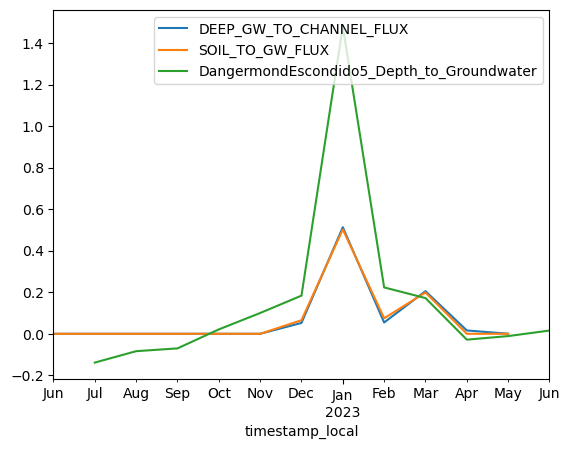

cat-73


<Figure size 640x480 with 0 Axes>

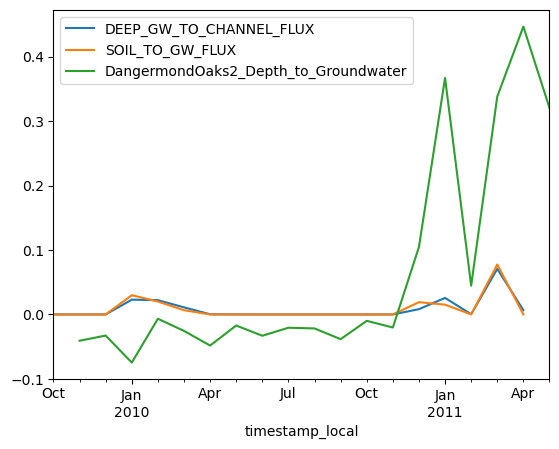

cat-62
subset error, cat not in ngen output
cat-94
subset error, cat not in ngen output
cat-38


<Figure size 640x480 with 0 Axes>

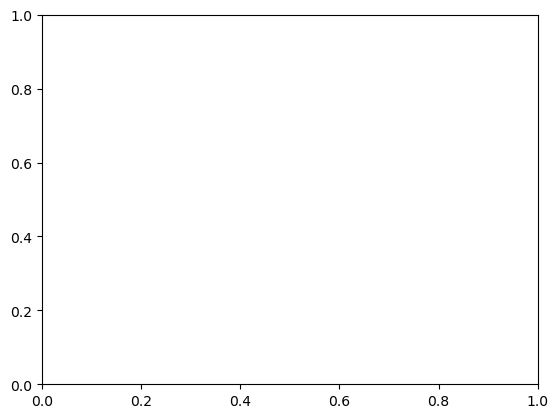

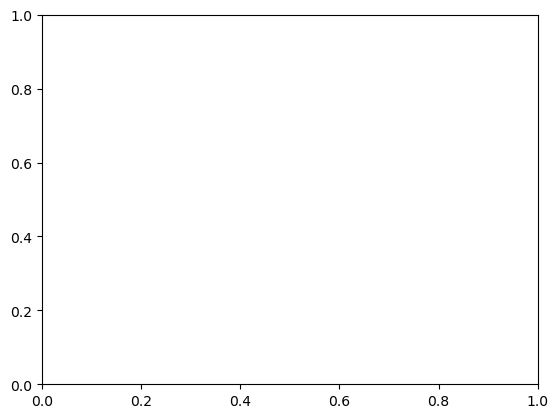

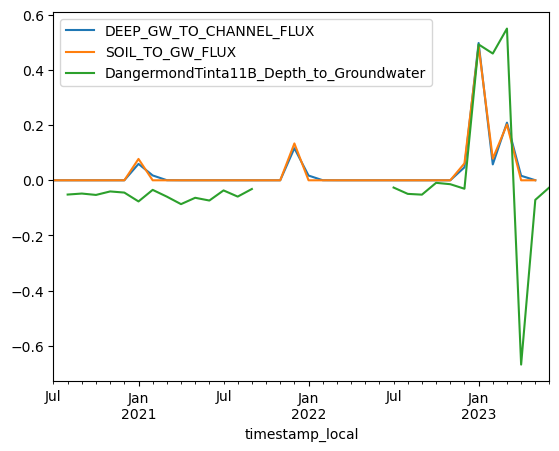

cat-30


<Figure size 640x480 with 0 Axes>

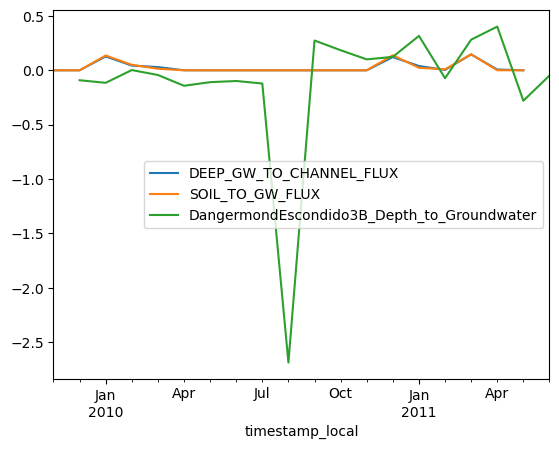

cat-8
subset error, cat not in ngen output
cat-31


<Figure size 640x480 with 0 Axes>

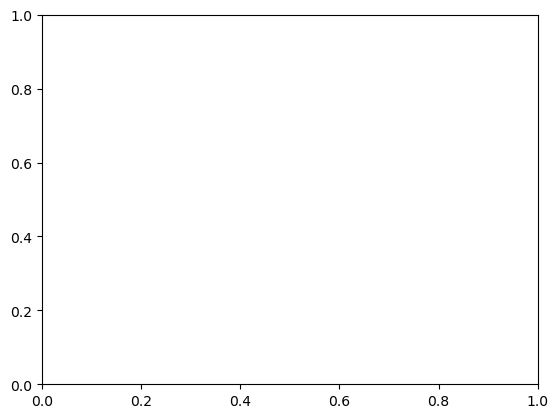

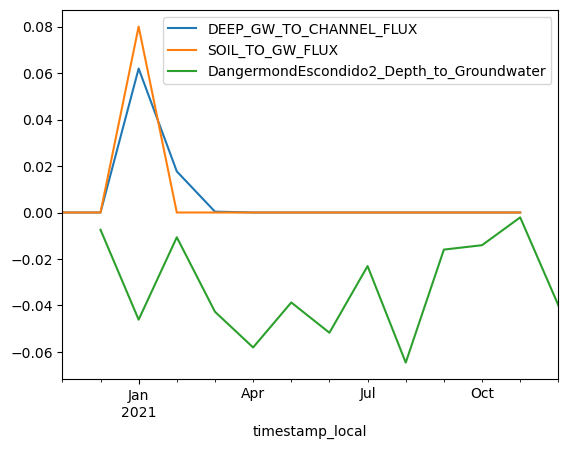

cat-30


<Figure size 640x480 with 0 Axes>

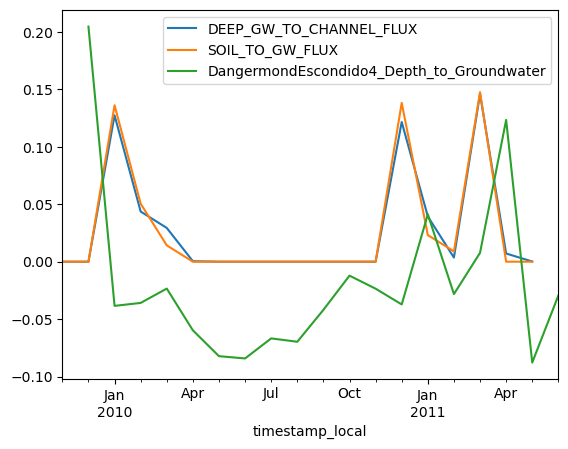

cat-8
subset error, cat not in ngen output
cat-53


<Figure size 640x480 with 0 Axes>

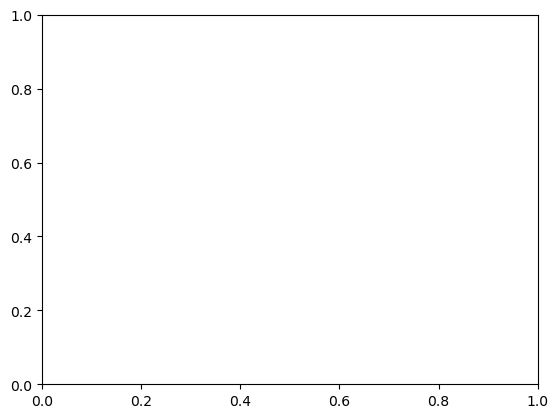

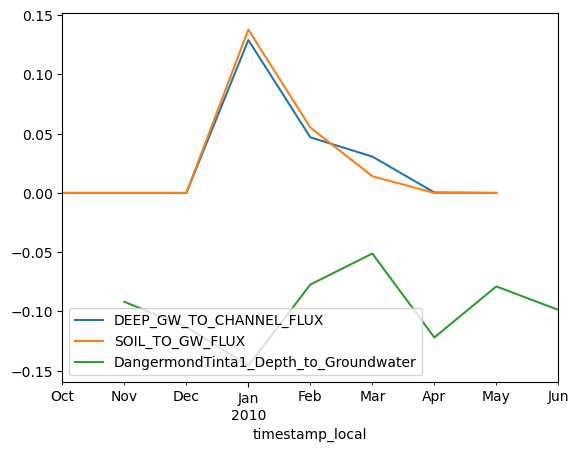

cat-53


<Figure size 640x480 with 0 Axes>

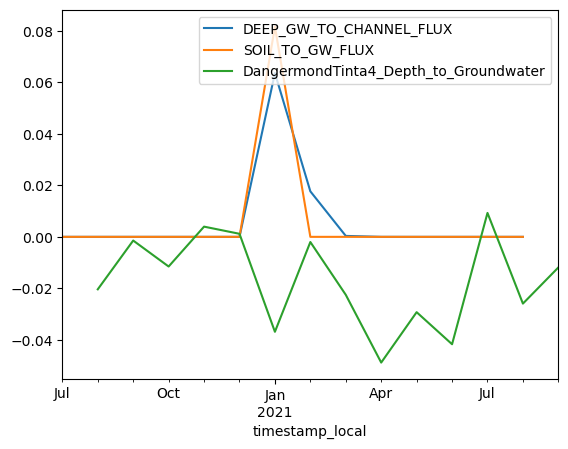

cat-53


<Figure size 640x480 with 0 Axes>

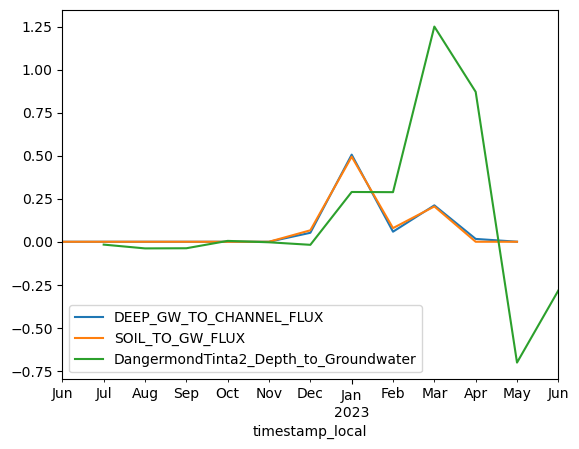

cat-8
subset error, cat not in ngen output
cat-53


<Figure size 640x480 with 0 Axes>

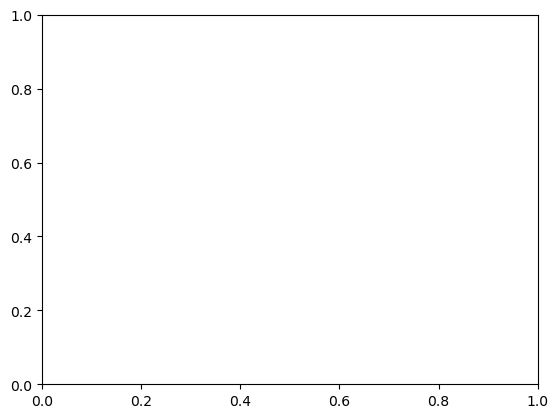

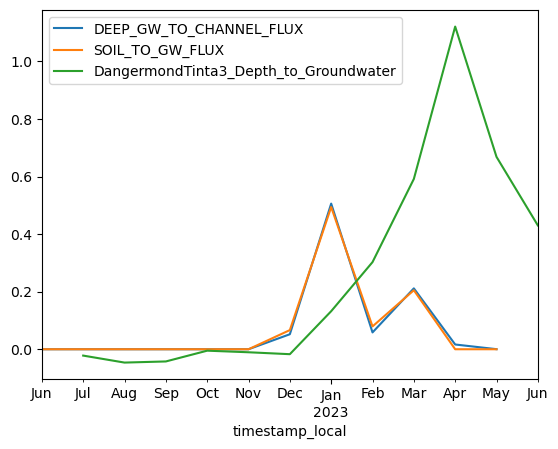

cat-54


<Figure size 640x480 with 0 Axes>

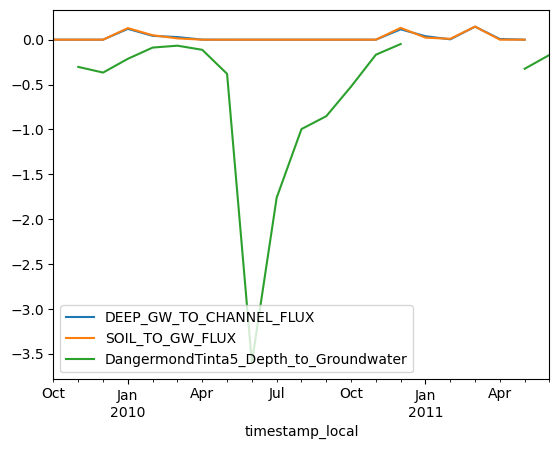

cat-10
subset error, cat not in ngen output
cat-93


<Figure size 640x480 with 0 Axes>

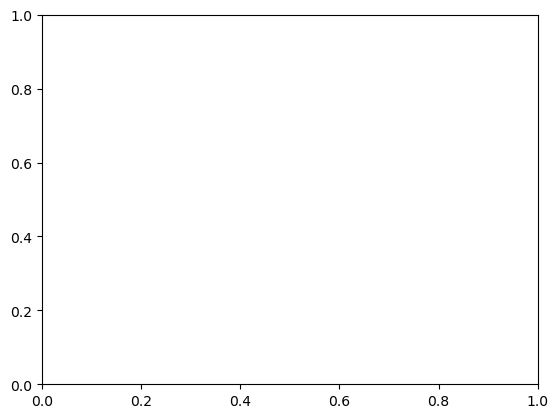

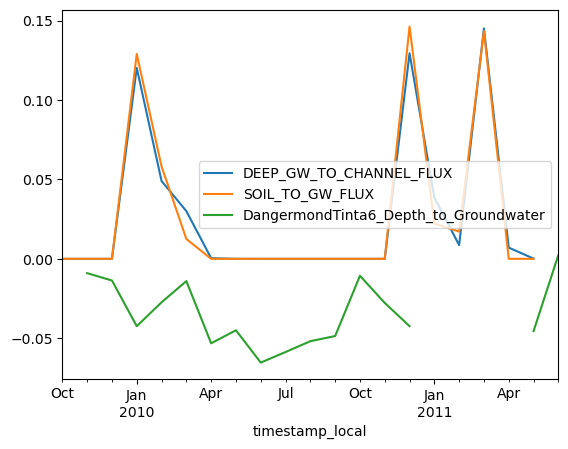

cat-8
subset error, cat not in ngen output
cat-30


<Figure size 640x480 with 0 Axes>

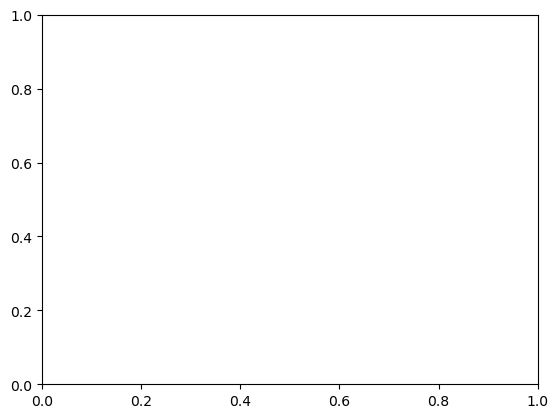

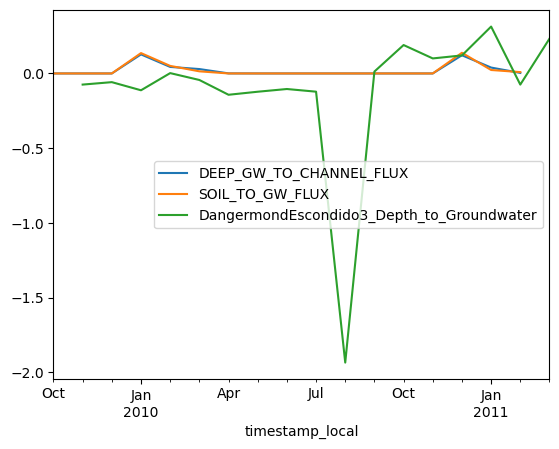

<Figure size 640x480 with 0 Axes>

In [17]:
for k, v in gw_deltas.items():
    fig, ax = plt.subplots()

    # get gw delta data
    df_delta = pd.DataFrame(v.iloc[:, 0])

    delta_min_index = df_delta.index.min()
    delta_max_index = df_delta.index.max()
    # look up catchment based on stn ide
    cat = locs_gdf[locs_gdf["station_id_dendra"] == k]["divide_id"].values[0]
    print(cat)
    # subset ng ds
    try:
        df_ng = (
            ds[["DEEP_GW_TO_CHANNEL_FLUX", "SOIL_TO_GW_FLUX"]]
            .sel({"catchment": cat})
            .to_pandas()
        )

        # df_ng['DEEP_GW_TO_CHANNEL_FLUX'] *= -1

        df_ng = (
            df_ng.resample("1ME")
            .sum()
            .truncate(before=delta_min_index, after=delta_max_index)
        )
        # print(df_ng)
        df_ng.plot(ax=ax)
        df_delta.plot(ax=ax)
        plt.show()
        plt.close()
        plt.figure()

    except KeyError:
        print("subset error, cat not in ngen output")
        continue